In [1]:
!pip install cloudant

In [2]:
#!pip install scikit-learn --upgrade

In [3]:
#!pip install lightgbm --upgrade

In [4]:
#!pip install xgboost --upgrade

In [5]:
#!pip install imblearn --upgrade

In [6]:
# Import de bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from cloudant import Cloudant

from sklearn.model_selection import train_test_split

# Import dos módulos
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import warnings
warnings.filterwarnings("ignore")


# Imports para formatação dos gráficos
import matplotlib as m
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 14,6

In [7]:
# Definicao das variaveis de conexao

user     = "ad7fd206-cbed-4b75-aa98-a9fd2e05c755-bluemix"
password = "a2537397c518fcd38947f38ce8c72c17903732bb61f838c05e5b56a29c9de0aa"
account  = "ad7fd206-cbed-4b75-aa98-a9fd2e05c755-bluemix" 
db_name  = "desafio7-iot"

In [8]:
# Funcao para carregar os dados do banco de dados NoSQL Cloudant
def obter_dados(user, password, account, db_name):

    client = Cloudant(user, password, account=account, connect=True, auto_renew=True)

    db = client[db_name]

    response = db.all_docs(limit=20000, include_docs=True)

    docs = []
    for r in response["rows"]:
        docs.append(r['doc'])

    return docs

# Verificando se existem registros duplicados no dataset
def verify_dup_rows(data):
    
    # Obtendo somente linhas duplicadas
    tmp = data[data.duplicated()]

    print("Linhas duplicadas até o momento:")
    print(tmp.shape)
    
    del tmp
    
    
# Funcao para verificar valores missing no dataset
def check_missing(df, display = 10):
    temp_df = df.copy()
    df_nan = (temp_df.isnull().sum() / len(temp_df)) * 100
    missing_data = pd.DataFrame({'Missing n': temp_df.isnull().sum(),'% Missing' :df_nan})
    if missing_data['Missing n'].sum() == 0:
        return print('Ótimo! Não há mais valores faltantes neste dataset.')
    else:
        return missing_data.sort_values('% Missing', ascending = False).head(display)

# Funcao para preencher os dados missing de algumas colunas
def preenche_missing(df):
    
    df.dropna(axis='index', how='any', subset=['Tempo', 'Estação', 'LAT', 'LONG', 
                                               'Movimentação', 'Original_473', 
                                               'Original_269', 'Zero', 'Maçã-Verde', 
                                               'Tangerina', 'Citrus', 'Açaí-Guaraná', 
                                               'Pêssego'])

    # coloca constante 0 em outras colunas com dados missing
    impute_zeros = SimpleImputer(
                                    missing_values=np.nan,
                                    strategy='constant',
                                    fill_value=0,
                                    verbose=0,
                                    copy=True
                                )
    
    impute_zeros.fit(X=df)

    # Reconstruindo um Pandas DataFrame com os resultados
    data = pd.DataFrame.from_records(
            data = impute_zeros.transform(
            X    = df
        ),
        columns=df.columns
    )    
    
    # Converte colunas para numerico
    data = data.apply(pd.to_numeric, errors='ignore')

    return data

# Funcao para trabalhar as features
def fe(df):

    # Removendo colunas unicas
    data = df.drop(['Tempo', 'Estação', 'LAT', 'LONG', 'Movimentação', '_id', '_rev', 'row'], axis = 1)

    # Removendo registros duplicados
    data = data.drop_duplicates().reset_index(drop=True)

    return data

# Funcao para transformar features categoricas em numericas
def fe_cat_num(df):

    # Tratando variáveis categóricas com o método Pandas ``get_dummies()''
    df = pd.get_dummies(df, columns=['xxxx'])

    return df    

In [9]:
# Criando um dataframe a partir da lista de dados vindo do IoT e gravados no NoSQL
train = pd.DataFrame(data=obter_dados(user, password, account, db_name))

# Carregando o dataset de testes 
test  = pd.read_csv(r'teste_desafio_7.csv')


In [10]:
# Feature Engineering
treino = preenche_missing(train)    
treino = fe(treino)   

# Removendo outliers
#treino = treino[treino['modulos_finalizados'] <= 500]

# Verificando as colunas com dados missing do dataset
check_missing(treino, display = 15)

print(treino.shape)

print('\n')
# Verificar os registros duplicados
verify_dup_rows(treino)

treino.head(10)

Ótimo! Não há mais valores faltantes neste dataset.
(4843, 9)


Linhas duplicadas até o momento:
(0, 9)


,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
0,86,11,12,24,25,10,15,17,NORMAL
1,30,51,42,24,13,24,43,1,NORMAL
2,86,14,24,42,37,22,23,33,NORMAL
3,77,36,65,28,25,33,30,3,NORMAL
4,66,57,53,9,8,22,8,23,NORMAL
5,22,13,18,14,18,33,41,21,NORMAL
6,79,55,49,39,41,19,32,3,REABASTECER
7,86,54,27,4,14,4,17,14,REABASTECER
8,37,9,45,18,1,35,24,30,NORMAL
9,32,31,19,10,40,14,17,34,NORMAL


In [11]:
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 9 columns):
Original_473    4843 non-null int64
Original_269    4843 non-null int64
Zero            4843 non-null int64
Maçã-Verde      4843 non-null int64
Tangerina       4843 non-null int64
Citrus          4843 non-null int64
Açaí-Guaraná    4843 non-null int64
Pêssego         4843 non-null int64
TARGET          4843 non-null object
dtypes: int64(8), object(1)
memory usage: 340.6+ KB


,TARGET,%
NORMAL,3248,67.065868
REABASTECER,1595,32.934132


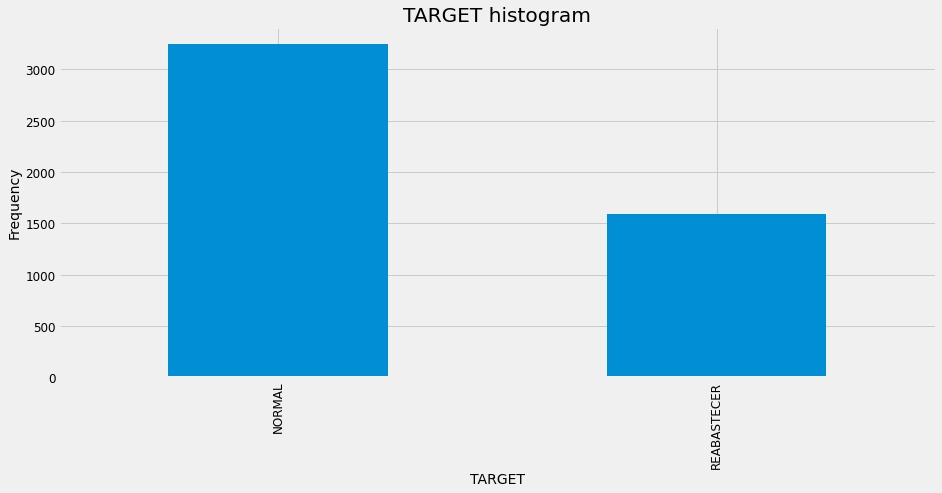

In [12]:
# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(treino['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(treino['TARGET'].value_counts())
tmp['%'] = 100*tmp['TARGET']/treino.shape[0]
tmp

In [13]:
# Selecionando features para treinamento
X = treino[['Original_473', 'Original_269', 'Zero', 'Maçã-Verde', 'Tangerina', 'Citrus', 'Açaí-Guaraná', 'Pêssego']]

# Selecionando feature target
y = treino['TARGET']

In [14]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_gbc = GradientBoostingClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_gbc.predict(X_valid)

# Salvando o score
gbc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.79      0.85      0.82       639
 REABASTECER       0.65      0.56      0.60       330

    accuracy                           0.75       969
   macro avg       0.72      0.70      0.71       969
weighted avg       0.74      0.75      0.74       969

F1_macro   :  0.7100963402997937
F1_micro   :  0.7492260061919505
F1_weighted:  0.7440600109758512
F1_none    :  [0.81660377 0.60358891]


In [15]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_lr = LogisticRegression().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_lr.predict(X_valid)

# Salvando o score
lr_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.68      0.91      0.78       639
 REABASTECER       0.48      0.16      0.24       330

    accuracy                           0.66       969
   macro avg       0.58      0.54      0.51       969
weighted avg       0.61      0.66      0.59       969

F1_macro   :  0.5089725694865882
F1_micro   :  0.6553147574819401
F1_weighted:  0.5944541121908675
F1_none    :  [0.77703605 0.24090909]


In [16]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_knn = KNeighborsClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_knn.predict(X_valid)

# Salvando o score
knn_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.69      0.85      0.76       639
 REABASTECER       0.49      0.27      0.35       330

    accuracy                           0.65       969
   macro avg       0.59      0.56      0.56       969
weighted avg       0.62      0.65      0.62       969

F1_macro   :  0.5559454191033139
F1_micro   :  0.6542827657378741
F1_weighted:  0.6225819105727856
F1_none    :  [0.76491228 0.34697856]


In [17]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_dtc = DecisionTreeClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_dtc.predict(X_valid)

# Salvando o score
dtc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.80      0.82      0.81       639
 REABASTECER       0.64      0.61      0.62       330

    accuracy                           0.75       969
   macro avg       0.72      0.72      0.72       969
weighted avg       0.75      0.75      0.75       969

F1_macro   :  0.7186033004694385
F1_micro   :  0.7502579979360166
F1_weighted:  0.7486996128299697
F1_none    :  [0.812983  0.6242236]


In [18]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_rfc = RandomForestClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_rfc.predict(X_valid)

# Salvando o score
rfc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.87      0.78      0.82       639
 REABASTECER       0.64      0.78      0.70       330

    accuracy                           0.78       969
   macro avg       0.76      0.78      0.76       969
weighted avg       0.79      0.78      0.78       969

F1_macro   :  0.7614223910520206
F1_micro   :  0.7760577915376677
F1_weighted:  0.7802654691772911
F1_none    :  [0.82051282 0.70233196]


In [19]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_xgb = XGBClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_xgb.predict(X_valid)

# Salvando o score
xgb_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.82      0.81      0.82       639
 REABASTECER       0.64      0.65      0.65       330

    accuracy                           0.76       969
   macro avg       0.73      0.73      0.73       969
weighted avg       0.76      0.76      0.76       969

F1_macro   :  0.7306184012066366
F1_micro   :  0.7574819401444789
F1_weighted:  0.7577453081732812
F1_none    :  [0.81568627 0.64555053]


In [20]:
# Prepara a lista de resultados
metricas = [(gbc_score),(lr_score),(knn_score),(dtc_score),(rfc_score),(xgb_score)]

# Cria o dataframe
df_metricas = pd.DataFrame(metricas, 
                           columns = ['Accuracy'], 
                           index = ['GBC', 'LR', 'KNN', 'DTC', 'RFC', 'XGB']) 

# Visualiza o resultado
df_metricas

,Accuracy
GBC,0.744060
LR,0.594454
KNN,0.622582
DTC,0.748700
RFC,0.780265
XGB,0.757745
